## Cálculo das curvas de referência e curvas SPR para diversos analitos

Importação das bibliotecas necessárias:

In [46]:
from scipy.integrate import *
from scipy.signal import butter, lfilter, freqz, filtfilt
from random import gauss, uniform
import sympy as smp
from numpy import *
from numpy import polynomial
import Reflectivity as ref
import Setting_Layers as sl
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import time

Importação de arquivos dos experimentos:

In [47]:
dados = pd.read_csv("experimento_H2O.csv", encoding='latin1')
dados2 = pd.read_csv("experimento_H2O_2.csv", encoding='latin1')
dados3 = pd.read_csv("experimento_H2O_1.csv", encoding='latin1')
dados4 = pd.read_csv("signal reference.csv", encoding='latin1')
dados_naoh = pd.read_csv("experimento_NAOH.csv", encoding='latin1')

pixel = dados['pixel']
signal_ref_AR = dados4['Reference']
signal_naoh = dados_naoh['Chan 1']

#signal = dados[' signal']*signal_ref_AR
signal = dados[' signal']

noise_term = []

theta_i = []

for i in pixel:
    theta_i.append((3.1522 * 1E-5 * i**2) - (0.0661 * i) + 73.4533)
    b = gauss(mean(0), 0.03)
    noise_term.append(b)

# Definição de função para calcular o indice de refração
def set_index_3(lambda_i, material):
    
    ref_index = (sl.set_index(material, lambda_i*1E-9))

    return ref_index

idx = lambda w_i, material: set_index_3(w_i, material)

In [48]:

dset1 = pd.read_csv("Default Dataset.csv", encoding='latin1')
dset1.dropna()

energy = dset1['E_2']/100000
lambda_i = dset1['l'] + dset1['L_2']/100000

p = polynomial.Polynomial.fit(lambda_i, energy, 20)


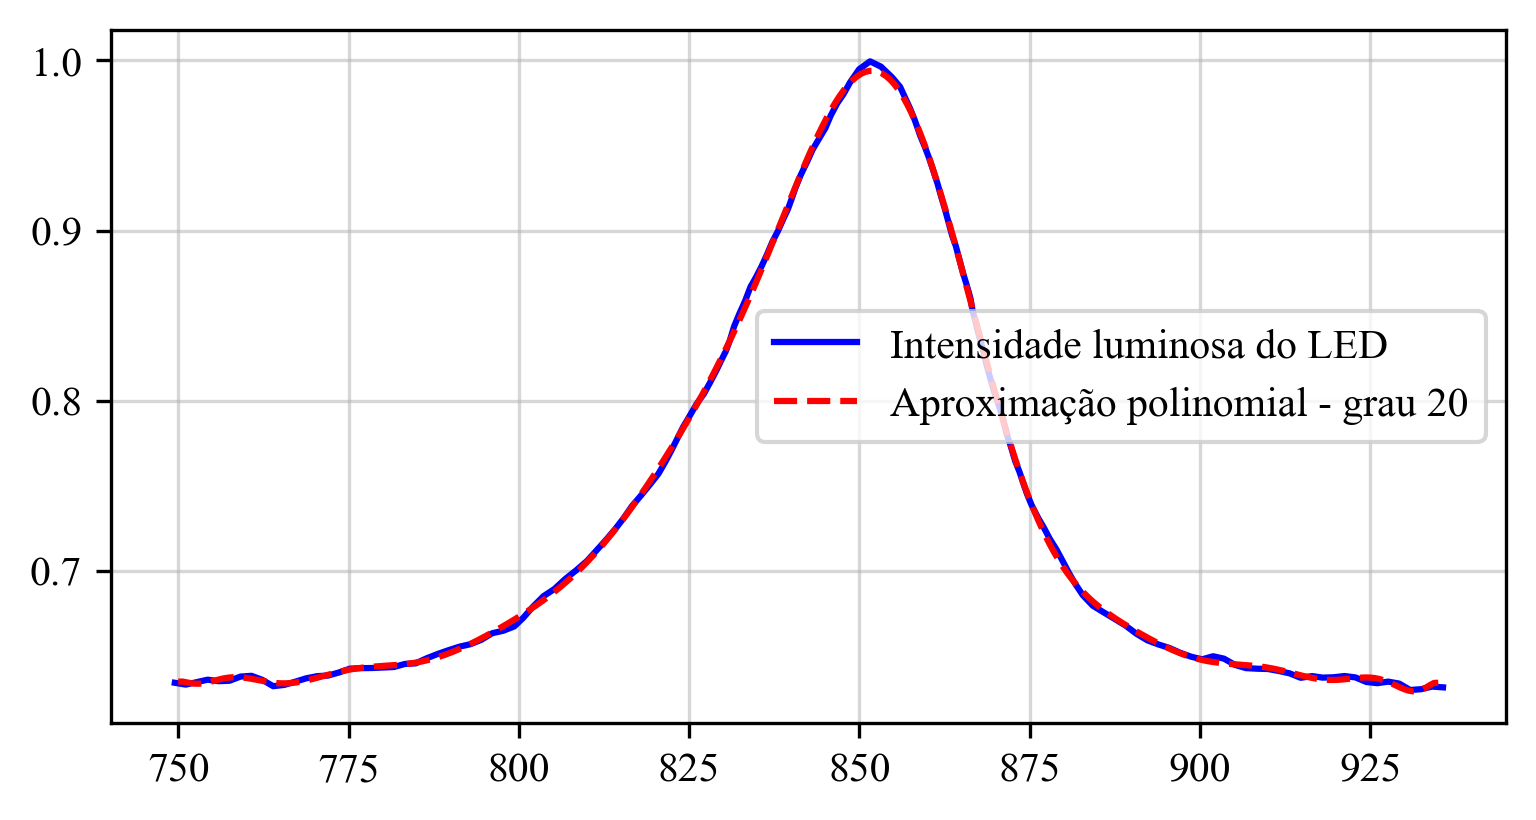

In [49]:
mpl.rc('font', family = 'Times New Roman')

x = list(linspace(750, 935, 300))
y=[]
yp = []
y2 = []
for i in x:
    a = p(i)
    yp.append(p(i))

fig, ax = plt.subplots(dpi = 300, figsize=(6,3))
plt.plot(lambda_i, energy, color ='b', label = "Intensidade luminosa do LED")
plt.plot(x, yp, '--',color = 'r', label = "Aproximação polinomial - grau 20")
plt.grid(True, alpha=0.5)
plt.legend()


### Inicio do cálculo para a curva de referência

Definição da função que calcula a reflectância

In [50]:

r = lambda theta, lambda_i: ref.reflectivity(3, [1, 50*1E-9, 1], [idx(lambda_i, 21), idx(lambda_i, 13), 1.33], theta*pi/180, lambda_i*1e-9)
    

Definição da função f($\lambda$,$\theta$) = r($\lambda$, $\theta$) $\cdot$ $\rho$ ($\lambda$) que modela a ponderação do espalhamento do LED em cada comprimento de onda.

In [51]:
def f(w_i, theta):
    return (r(theta, w_i)*p(w_i))

Definição da integral $\int_{\lambda_I}^{\lambda_F} r(\lambda, \theta)* p(\lambda)\,d\lambda$

In [52]:
integrals = [[a, quad(f,  750, 930, args=(a))[0]] for a in theta_i]

C:\Users\Adeilson\AppData\Local\Temp\ipykernel_8820\530931226.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrals = [[a, quad(f,  750, 930, args=(a))[0]] for a in theta_i]
C:\Users\Adeilson\AppData\Local\Temp\ipykernel_8820\530931226.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrals = [[a, quad(f,  750, 930, args=(a))[0]] for a in theta_i]


Resolução da equação: $R(\theta)$ = $\frac{\int_{\lambda_I}^{\lambda_F} r(\lambda, \theta)* p(\lambda)\,d\lambda}{\rho(\lambda)}$
e normalização de $R(\theta)$ pelo seu valor máximo

In [53]:
reflectancia= array(integrals).T[1] / quad(p, 750, 930)[0]
reflectancia_norm = reflectancia/max(reflectancia)

Incremento do ruído térmico no sinal de tensão resultado de 'reflectancia_norm*noise_ref'

In [54]:
reflectancia_norm = (reflectancia_norm)*signal_ref_AR

Criação do arquivo para salvar os dados da curva de referência

Plotagem do sinal de referência para verificação

Text(0, 0.5, 'Reflectância normalizada')

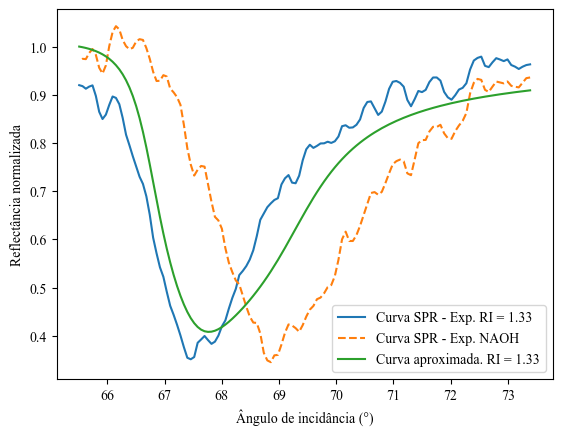

In [55]:
plt.subplots(dpi=100)
plt.plot(theta_i, signal, '-', label= 'Curva SPR - Exp. RI = 1.33')
plt.plot(theta_i, signal_naoh/signal_ref_AR, '--', label= 'Curva SPR - Exp. NAOH')
plt.plot(theta_i, (reflectancia_norm)/signal_ref_AR,'-', label= 'Curva aproximada. RI = 1.33' )
plt.legend()
plt.xlabel("Ângulo de incidância (°)")
plt.ylabel("Reflectância normalizada")



In [56]:
noise_space = []
for i in range(len(theta_i)):
    noise_space.append((signal) - (reflectancia_norm[i]/signal_ref_AR[i]))

spr_result = ((reflectancia_norm) + noise_term) / signal_ref_AR + noise_space
plt.subplots(dpi=100)
plt.plot(theta_i, signal_naoh/signal_ref_AR, '--', label= 'Signal Exp NAOH')
plt.plot(theta_i, spr_result, label="Curva SPR gerada - ajuste polinomial")
plt.plot(theta_i, signal, label = "Curva Experimental")
plt.xlabel("Ângulo de incidância (°)")
plt.ylabel("Reflectância normalizada")
plt.legend()
plt.show()

ValueError: Data must be 1-dimensional

### Calculo do FWHM e Linha Base

In [ ]:
y = list((reflectancia_norm)/signal_ref_AR)

id_min = y.index(min(y))

y_left = y[0:id_min]
y_right = y[id_min-1:len(y)]

y_mx_left = max(y_left)
y_mn_left = min(y_left)

y_mx_right = max(y_right)
y_mn_right = min(y_right)

y_med_left = (y_mx_left + y_mn_left)/2
y_med_right = (y_mx_right + y_mn_right)/2

y_med = (y_med_left + y_med_right)/2

signs = sign(add(y, -y_med))

zero_crossings = (signs[0:-2] != signs[1:-1])
zero_crossings_i = where(zero_crossings)[0]

id = zero_crossings_i[1]
j = zero_crossings_i[0]

x1 = theta_i[id] + (theta_i[id+1] - theta_i[id]) * ((y_med - y[id]) / (y[id+1] - y[id]))
x2 = theta_i[j] + (theta_i[j+1] - theta_i[j]) * ((y_med - y[j]) / (y[j+1] - y[j]))

print(x1, x2)
print(id, j)



66.86161705135359 69.57676621698756
103 59


### Verificação do angulo de ressonancia

1.3291959355935898
90


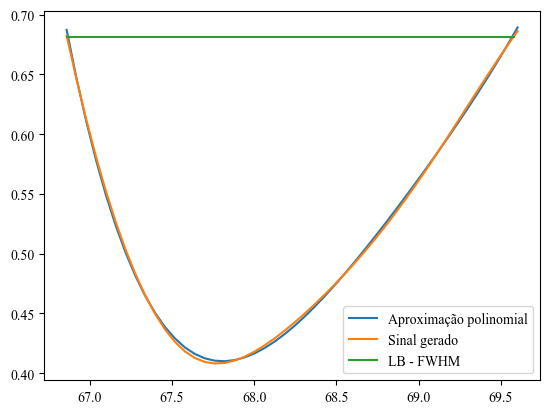

In [ ]:
from scipy import optimize

r = list((reflectancia_norm)/signal_ref_AR)

id_resonance = r.index(min(r))
x = theta_i[j:id+2]
y = r[j:id+2]

yz=[]
z = polynomial.Polynomial.fit(x, y, 4)
for i in x:
    yz.append(z(i))

res_angle = optimize.fminbound(z, theta_i[(id+1)] ,theta_i[(j)] ) 


n_au = sl.set_index(13, 850*1E-9)
emr = real(n_au)**2 - imag(n_au)**2

index_analyte = sqrt((emr*(1.4826 * sin(res_angle*pi/180))**2)/
(emr-(1.4826*sin(res_angle*pi/180))**2))

plt.plot(x, yz, label = "Aproximação polinomial")
plt.plot(x, y, label = "Sinal gerado")
#plt.plot(theta_i, signal)
plt.plot([x1, x2], [y_med, y_med], label = "LB - FWHM")
plt.legend()


print(index_analyte)
pixel_res = pixel[id_resonance]
print(pixel_res)

In [ ]:
arquivo = open('Reference_data_wet.csv','w')
arquivo.write("Pixel #,Angle,Signal,Noise_Ref,Noise_term,Noise_space")
for i in range(len(theta_i)):
    arquivo.write(f"\n{pixel[i]},{theta_i[i]},{reflectancia_norm[i]},{signal_ref_AR[i]},{noise_term[i]},{noise_space[i]}")
arquivo.close()

### A partir daqui será o calculo das curvas para um analido com IR > 1.32 RIU

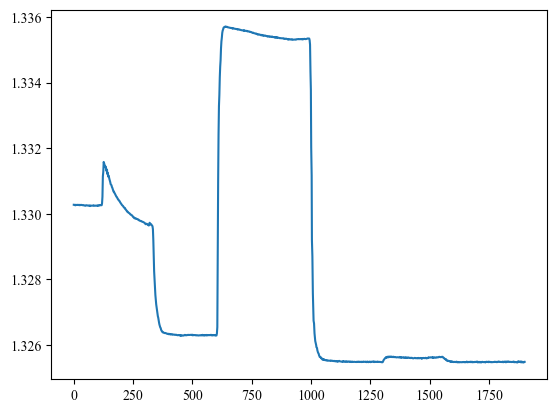

In [ ]:
dados_raw = pd.read_csv("raw data.csv", encoding='latin1')

ri = dados_raw["Refractive Index"]
t = dados_raw["Time(s)"]
t = [float(i) for i in t]
plt.plot(t,ri, "-")



## geração das curvas

In [ ]:
"""start_time = time.time()
arquivo = open('Sensor_data.txt','w')
arquivo.write("time(s)\tAngle\tSignal\tSPR Curve")

signal_ref_txt = pd.read_csv('Reference_data_wet.csv', encoding='latin1')

pixel_ = signal_ref_txt['Pixel #']
angle_ = signal_ref_txt['Angle']
signal_ref = signal_ref_txt['Noise_Ref']
theta_i = []
noise_term = gauss(0, 0.5)
noise_space = signal_ref_txt['Noise_space']

for i in pixel_:
    theta_i.append((3.1522 * 1E-5 * i**2) - (0.0661 * i) + 73.4533)

for i in ri:
    r = lambda theta, lambda_i: ref.reflectivity(3, [1, 50*1E-9, 1], [idx(lambda_i, 21), idx(lambda_i, 13), i], theta*pi/180, lambda_i*1e-9)

    def f(w_i, theta):
        return (r(theta, w_i)*p(w_i))

    #Integral
    integrals = [[a, quad(f,  750, 930, args=(a))[0]] for a in linspace(73.6572,65.65896, 128)]

    reflectancia = array(integrals).T[1] / quad(p, 750, 930)[0]

    reflectancia_norm = reflectancia/max(reflectancia)

    reflectancia_norm = ((reflectancia_norm + noise_space) * signal_ref) + noise_term

    end_time = time.time()
    interval = round((end_time - start_time), 5)
    
    arquivo.write(f"\n{interval}\t{theta_i}\t{list(reflectancia_norm)}\t{list(reflectancia_norm/signal_ref)}")

arquivo.close()

    #angle_ = signal_sensor['Angle']
    #signal_ = signal_sensor['SPR Curve']

    #plt.plot(theta_i, signal, '--', label= 'Signal Exp 1')
    #plt.plot(angle_, (signal_),'--', label= 'Signal Ref TXT' )
    #plt.plot(theta_i, r/signal_ref, '--', label= 'Signal Simulated')
    #plt.legend()"""
    

'start_time = time.time()\narquivo = open(\'Sensor_data.txt\',\'w\')\narquivo.write("time(s)\tAngle\tSignal\tSPR Curve")\n\nsignal_ref_txt = pd.read_csv(\'Reference_data_wet.csv\', encoding=\'latin1\')\n\npixel_ = signal_ref_txt[\'Pixel #\']\nangle_ = signal_ref_txt[\'Angle\']\nsignal_ref = signal_ref_txt[\'Noise_Ref\']\ntheta_i = []\nnoise_term = gauss(0, 0.5)\nnoise_space = signal_ref_txt[\'Noise_space\']\n\nfor i in pixel_:\n    theta_i.append((3.1522 * 1E-5 * i**2) - (0.0661 * i) + 73.4533)\n\nfor i in ri:\n    r = lambda theta, lambda_i: ref.reflectivity(3, [1, 50*1E-9, 1], [idx(lambda_i, 21), idx(lambda_i, 13), i], theta*pi/180, lambda_i*1e-9)\n\n    def f(w_i, theta):\n        return (r(theta, w_i)*p(w_i))\n\n    #Integral\n    integrals = [[a, quad(f,  750, 930, args=(a))[0]] for a in linspace(73.6572,65.65896, 128)]\n\n    reflectancia = array(integrals).T[1] / quad(p, 750, 930)[0]\n\n    reflectancia_norm = reflectancia/max(reflectancia)\n\n    reflectancia_norm = ((reflectan

Verificação dos dados gerados:

In [ ]:
"""signal_sensor = pd.read_csv('Sensor_data.txt', encoding='latin1', delimiter='\t')
angle_ = []
signal_ = []
for i in linspace(0, 999, 10):
    a = signal_sensor['Angle'][i].replace('[', '').replace(']', '').replace(' ', '')
    s = signal_sensor['SPR Curve'][i].replace('[', '').replace(']', '').replace(' ', '')

    a = a.split(',')
    a = [float(i) for i in a]
    s = s.split(',')
    s = [float(i) for i in s]
    angle_.append(a)
    signal_.append(s)"""

"signal_sensor = pd.read_csv('Sensor_data.txt', encoding='latin1', delimiter='\t')\nangle_ = []\nsignal_ = []\nfor i in linspace(0, 999, 10):\n    a = signal_sensor['Angle'][i].replace('[', '').replace(']', '').replace(' ', '')\n    s = signal_sensor['SPR Curve'][i].replace('[', '').replace(']', '').replace(' ', '')\n\n    a = a.split(',')\n    a = [float(i) for i in a]\n    s = s.split(',')\n    s = [float(i) for i in s]\n    angle_.append(a)\n    signal_.append(s)"

In [ ]:
"""for i in linspace(0, 999, 10):
    plt.plot(angle_[i], signal_[i])
plt.show()"""

'for i in linspace(0, 999, 10):\n    plt.plot(angle_[i], signal_[i])\nplt.show()'